## Load SDSS image data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

f = fits.open('/home/regier/bliss/tests/data/sdss/2583/2/136/frame-r-002583-2-0136.fits')
w = WCS(f[0].header)

# lower-left corner of the 100x100-pixel study area is at pixel (310, 630)
w.pixel_to_world(310, 630)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (323.33025022, -0.81252688)>

Behold, the M2 globular cluster!


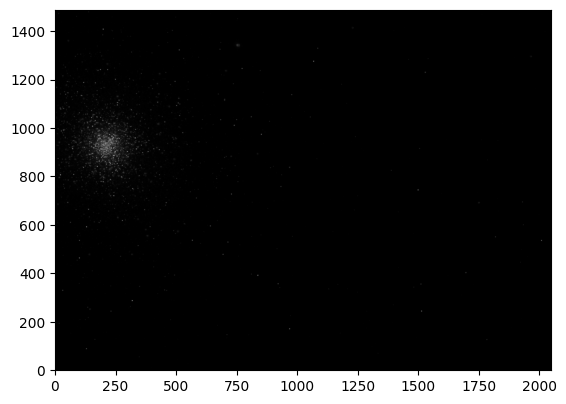

In [3]:
from matplotlib import pyplot as plt

plt.imshow(f[0].data, origin='lower', cmap='Greys_r')
print("Behold, the M2 globular cluster!")

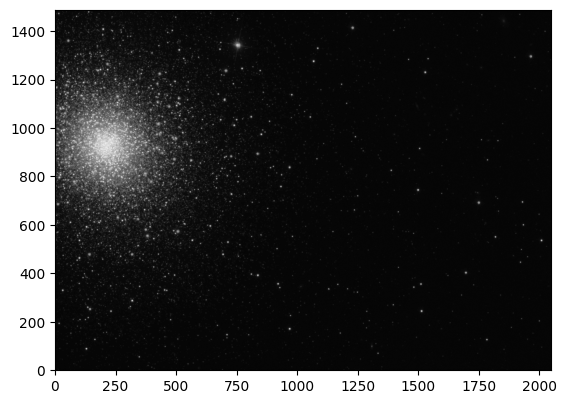

In [4]:
logimage = np.log(f[0].data - f[0].data.min() + 1)
plt.imshow(logimage, origin='lower', cmap='Greys_r');

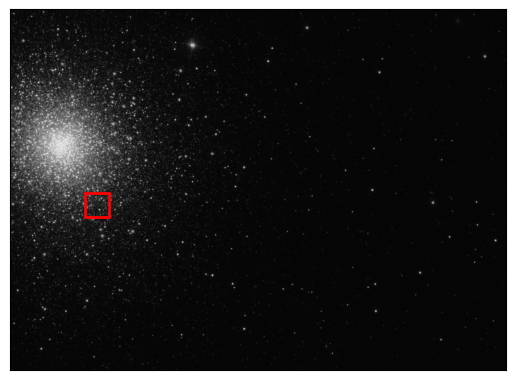

In [5]:
from matplotlib.patches import Rectangle

plt.imshow(logimage, origin='lower', cmap='Greys_r')
rect = Rectangle((310, 630), 100, 100, linewidth=2, edgecolor='r', facecolor='none')
_ = plt.gca().add_patch(rect)
plt.xticks([])
plt.yticks([]);

## Loading/viewing HST predictions

In [6]:
from bliss.catalog import FullCatalog
import torch
import numpy as np

# wget https://archive.stsci.edu/pub/hlsp/acsggct/ngc7089/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
hubble_cat_file = "/home/regier/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt"
hubble_cat = np.loadtxt(hubble_cat_file, skiprows=3, usecols=(9,21,22))

hst_r_mag_all = torch.from_numpy(hubble_cat[:, 0])
ra = torch.from_numpy(hubble_cat[:, 1])
dec = torch.from_numpy(hubble_cat[:, 2])

plocs_all = FullCatalog.plocs_from_ra_dec(ra, dec, w)

In [7]:
original = f[0].data[630:730, 310:410]

arcsinh_median = np.arcsinh((original - np.median(original)))

clipped = original.clip(max=np.quantile(original, 0.98))
arcsinh_clipped = np.arcsinh((clipped - np.median(clipped)));

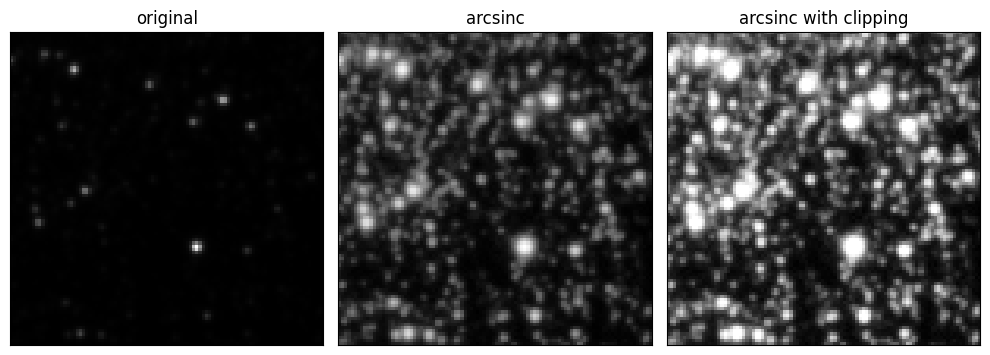

In [8]:


fig, axs = plt.subplots(1, 3, figsize=(10, 10))

images = [original, arcsinh_median, arcsinh_clipped]
titles = ['original', 'arcsinc', 'arcsinc with clipping']

for i, img in enumerate(images):
    ax = axs[i]
    ax.imshow(img, origin='lower', cmap='Greys_r')
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [9]:
in_bounds = (plocs_all[:, 1] > 310) & (plocs_all[:, 1] < 410)
in_bounds &= (plocs_all[:, 0] > 630) & (plocs_all[:, 0] < 730)
in_bounds.sum()

tensor(6048)

In [10]:
hst_r_mag = hst_r_mag_all[in_bounds]
plocs = plocs_all[in_bounds]

In [11]:
plocs_square = plocs - torch.tensor([630, 310])

from bliss.catalog import convert_mag_to_nmgy, convert_nmgy_to_mag
hst_r_nmgy = convert_mag_to_nmgy(hst_r_mag)

# these magnitudes are about 15% off: the hubble fw606 band filter curve
#  isn't exactly the sdss r band filter curve
sdss_r_nmgy = hst_r_nmgy * 1.15
sdss_r_mag = convert_nmgy_to_mag(sdss_r_nmgy)

In [12]:
d = {
    "plocs": plocs_square.unsqueeze(0),
    "star_fluxes": sdss_r_nmgy.unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]),
    "galaxy_fluxes": sdss_r_nmgy.unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]) * 0.0,
    "n_sources": torch.tensor(plocs.shape[0]).unsqueeze(0),
    "source_type": torch.zeros(plocs.shape[0]).unsqueeze(0).unsqueeze(2).long(),
}

In [13]:
true_cat_all = FullCatalog(100, 100, d)
true_cat_all["n_sources"].sum()

tensor(6048)

In [14]:
true_tile_cat_all = true_cat_all.to_tile_catalog(2, 11)
true_tile_cat_all["n_sources"].sum()

tensor(6048)

In [15]:
is_bright = sdss_r_mag < 22.565
is_bright.sum(), convert_mag_to_nmgy(22.565)

(tensor(1339), 0.9418895965228402)

In [16]:
d = {
    "plocs": plocs_square[is_bright].unsqueeze(0),
    "star_fluxes": sdss_r_nmgy[is_bright].unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]),
    "galaxy_fluxes": sdss_r_nmgy[is_bright].unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]) * 0.0,
    "n_sources": torch.tensor(plocs[is_bright].shape[0]).unsqueeze(0),
    "source_type": torch.zeros(plocs[is_bright].shape[0]).unsqueeze(0).unsqueeze(2).long(),
}
true_cat = FullCatalog(100, 100, d)
true_cat["n_sources"].sum()

tensor(1339)

In [17]:
true_tile_cat = true_cat.to_tile_catalog(2, 5)
true_tile_cat["n_sources"].sum()

tensor(1339)

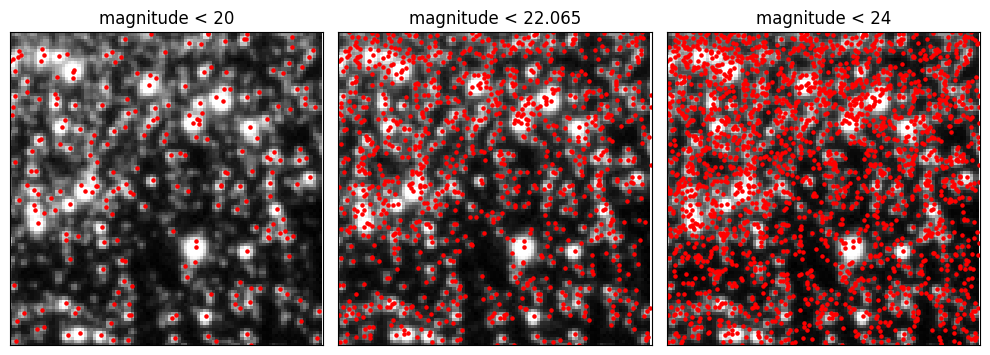

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

cutoffs = [20, 22.065, 24]

for i, cutoff in enumerate(cutoffs):
    is_bright = sdss_r_mag < cutoff
    plocs_square_bright = plocs_square[is_bright]
    ax = axs[i]
    ax.imshow(arcsinh_clipped, origin='lower', cmap='Greys_r')
    ax.scatter(plocs_square_bright[:, 1], plocs_square_bright[:, 0], s=5, c='r')
    ax.set_title(f"magnitude < {cutoff}")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## Making predictions on M2 with BLISS

In [19]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "2"

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg = compose("m2_config", {
        "encoder.tiles_to_crop=3",
        "predict.weight_save_path=/home/regier/bliss/output/jun11_yaml_vd/version_0/checkpoints/best_encoder.ckpt",
 #       "encoder.double_detect=false"
        })

In [20]:
bliss_cats = predict(cfg.predict)
bliss_cat_pair, = bliss_cats.values()
bliss_cat = bliss_cat_pair["mode_cat"].to_full_catalog()
true_cat["n_sources"].sum(), bliss_cat["n_sources"].sum()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting: 0it [00:00, ?it/s]

(tensor(1339), tensor(1245))

In [21]:
from hydra.utils import instantiate

matcher = instantiate(cfg.encoder.matcher)
metrics = instantiate(cfg.encoder.metrics)

In [22]:
matching = matcher.match_catalogs(true_cat, bliss_cat)
metric = metrics(true_cat, bliss_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

(tensor(0.5576), tensor(0.5686), tensor(0.5630))

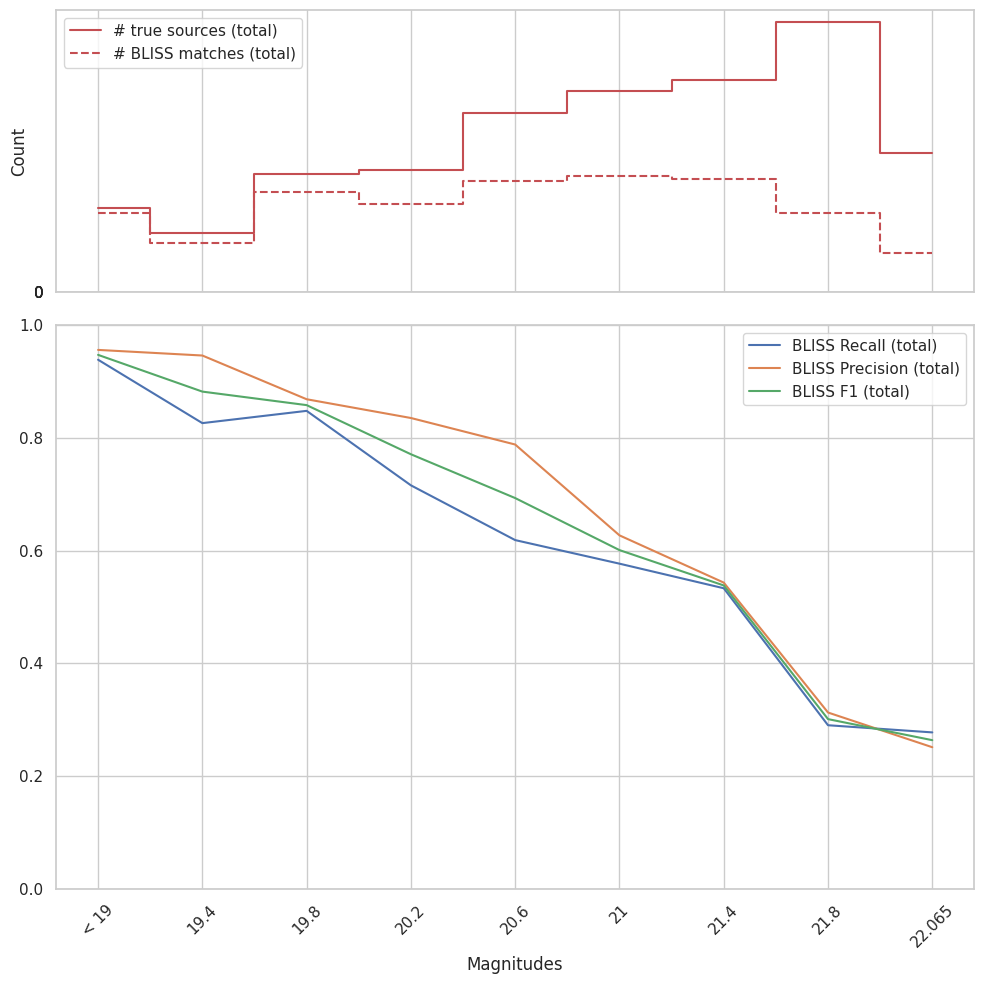

In [23]:
for name, metric in metrics.items():
    metric.plot()

In [24]:
m = metrics["detection_performance"]
recall = (m.n_true_matches / m.n_true_sources)[:-1]
precision = (m.n_est_matches / m.n_est_sources)[:-1]
real = {"recall": recall, "precision": precision}

Check calibration:

In [25]:
%%capture
counts = []

for i in range(15):
    bliss_cats = predict(cfg.predict)
    bliss_cat_pair, = bliss_cats.values()
    bliss_cat = bliss_cat_pair["sample_cat"].to_full_catalog()
    counts.append(bliss_cat["n_sources"].sum())

counts

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), us

In [26]:
cs = torch.tensor([c.item() for c in counts]).float()
cs.mean(), cs.quantile(0.05), cs.quantile(0.95)

(tensor(1462.2667), tensor(1437.2000), tensor(1489.9000))

### Independent tiling (baseline)

In [27]:
from copy import deepcopy
cfg2 = deepcopy(cfg)
cfg2.encoder.use_checkerboard = False

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting: 0it [00:00, ?it/s]

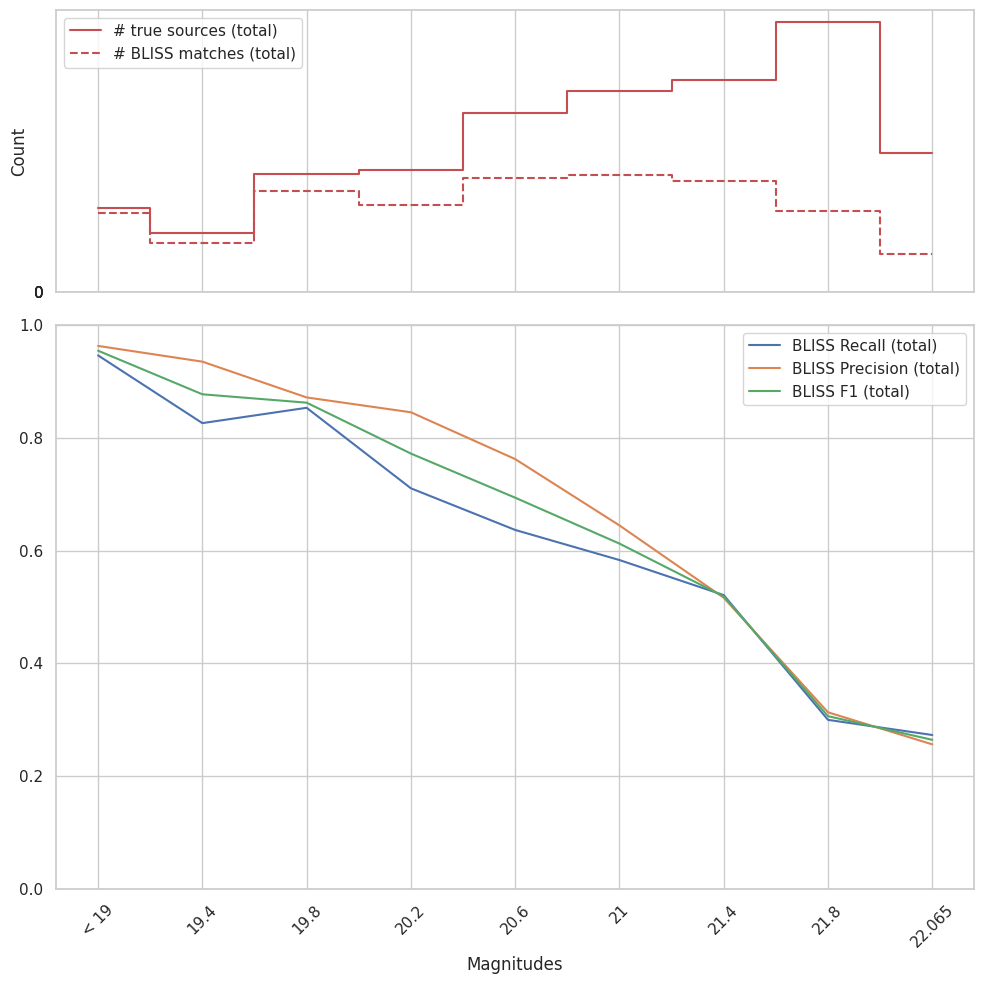

(tensor(0.5641), tensor(0.5572), tensor(0.5607))

In [28]:
bliss_cats = predict(cfg2.predict)
bliss_cat_pair, = bliss_cats.values()
bliss_cat_marginal = bliss_cat_pair["mode_cat"].to_full_catalog()
matching = matcher.match_catalogs(true_cat, bliss_cat_marginal)
metric = metrics(true_cat, bliss_cat_marginal, matching)

m = metrics["detection_performance"]
m.plot()

metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

In [29]:
%%capture
counts = []

for i in range(15):
    bliss_cats = predict(cfg2.predict)
    bliss_cat_pair, = bliss_cats.values()
    bliss_cat = bliss_cat_pair["sample_cat"].to_full_catalog()
    counts.append(bliss_cat["n_sources"].sum())

counts

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True (cuda), us

In [30]:
cs = torch.tensor([c.item() for c in counts]).float()
cs.mean(), cs.quantile(0.05), cs.quantile(0.95)

(tensor(1484.4667), tensor(1455.1000), tensor(1511.6000))

## BLISS performance on synthetic data

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

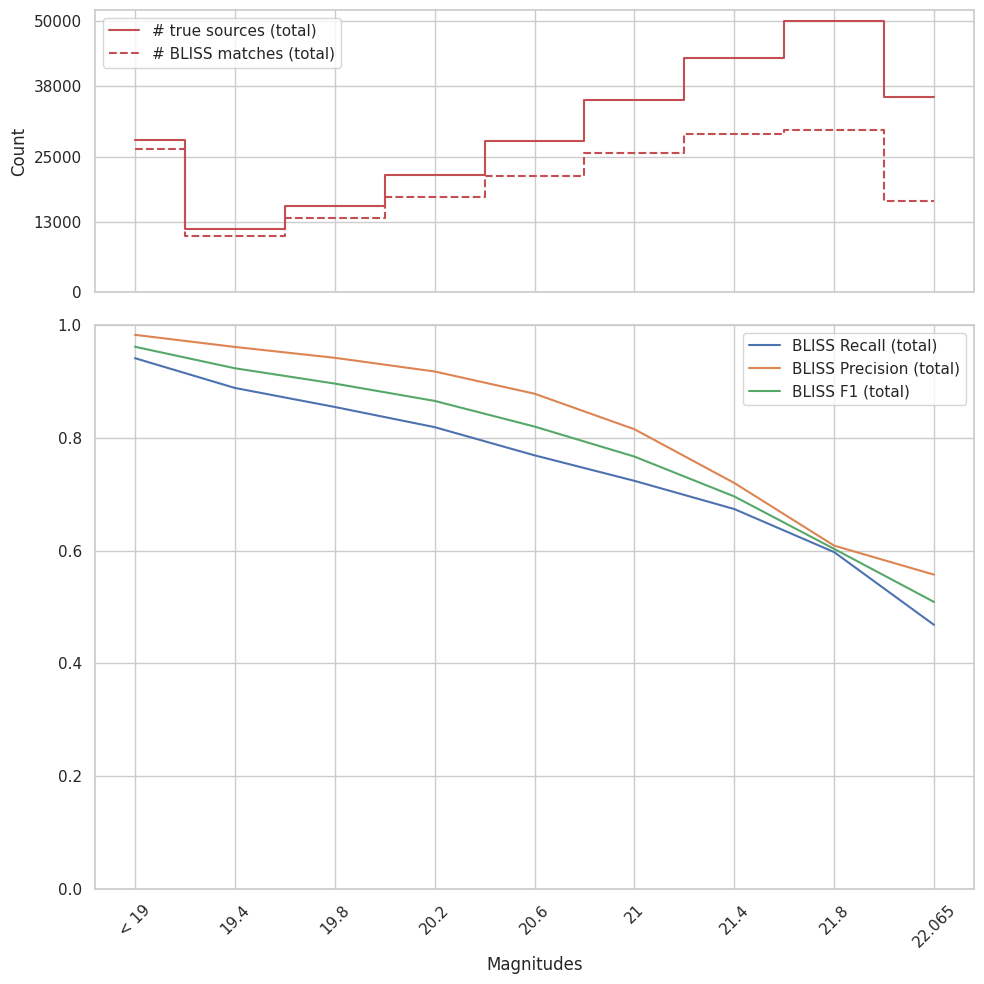

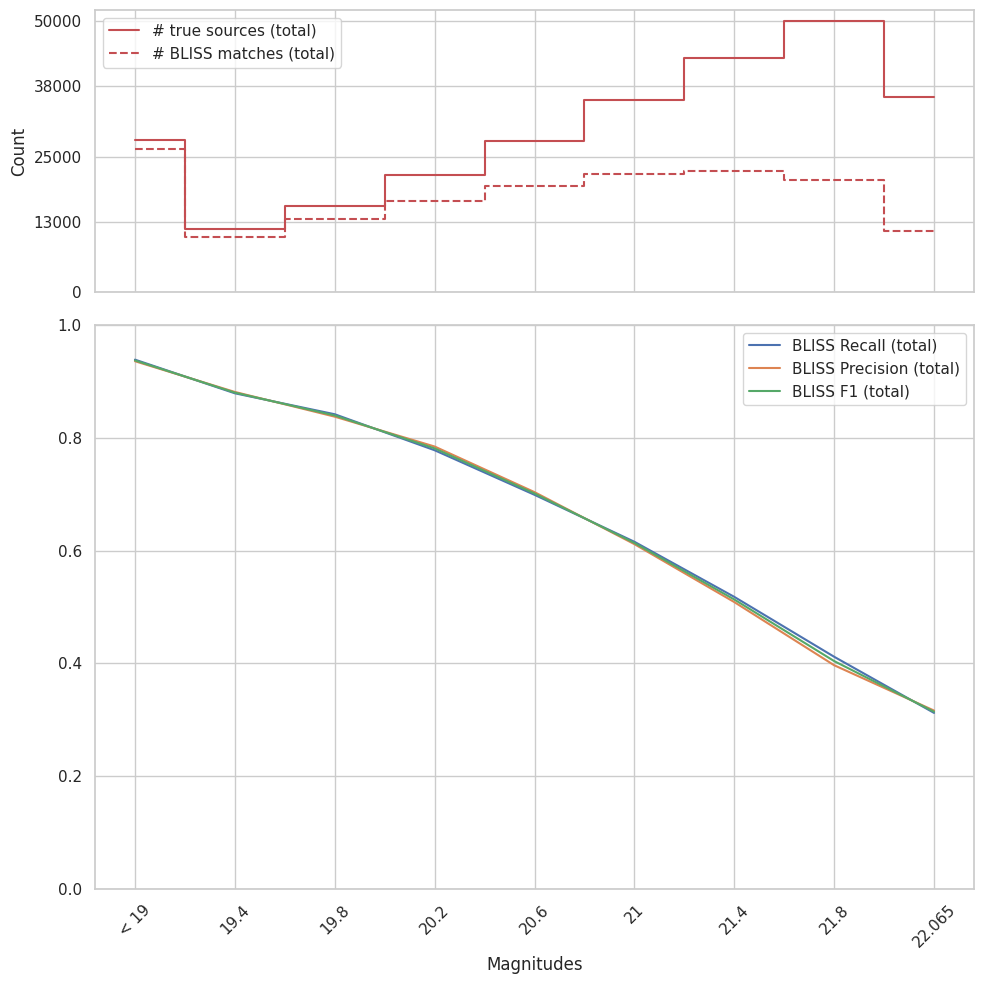

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric              ┃             DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              test/_loss               │          2.9384894371032715           │
│        test/mode/detection_f1         │          0.7334432601928711           │
│     test/mode/detection_f1_bin_0      │          0.9614858627319336           │
│     test/mode/detection_f1_bin_1      │          0.9233664274215698           │
│     test/mode/detection_f1_bin_2      │          0.8961983919143677           │
│     test/mode/detection_f1_bin_3      │          0.8654972910881042           │
│     test/mode/detection_f1_bin_4      │          0.8200111389160156           │
│     test/mode/detection_f1_bin_5      │          0.7668112516403198           │
│     test/mode/detection_f1_bin_6      │           0.696106493473053           │
│     test/mode/detection_f1_bin_7      │          0.6030840873718262           │
│     test/mode/detection_f1_bin_8      │          0.5090188980102539           │
│     test/mode/detection_precision     │          0.7607921361923218           │
│  test/mode/detection_precision_bin_0  │          0.9826136231422424           │
│  test/mode/detection_precision_bin_1  │          0.9611303806304932           │
│  test/mode/detection_precision_bin_2  │           0.941880464553833           │
│  test/mode/detection_precision_bin_3  │           0.91761714220047            │
│  test/mode/detection_precision_bin_4  │          0.8782570362091064           │
│  test/mode/detection_precision_bin_5  │          0.8152848482131958           │
│  test/mode/detection_precision_bin_6  │          0.7199792861938477           │
│  test/mode/detection_precision_bin_7  │          0.6088945269584656           │
│  test/mode/detection_precision_bin_8  │          0.5573916435241699           │
│      test/mode/detection_recall       │          0.7079923152923584           │
│   test/mode/detection_recall_bin_0    │          0.9412475824356079           │
│   test/mode/detection_recall_bin_1    │          0.8884578943252563           │
│   test/mode/detection_recall_bin_2    │          0.8547426462173462           │
│   test/mode/detection_recall_bin_3    │          0.8189799189567566           │
│   test/mode/detection_recall_bin_4    │          0.7690104246139526           │
│   test/mode/detection_recall_bin_5    │          0.7237783074378967           │
│   test/mode/detection_recall_bin_6    │          0.6737660765647888           │
│   test/mode/detection_recall_bin_7    │          0.5973833799362183           │
│   test/mode/detection_recall_bin_8    │          0.4683716595172882           │
│       test/sample/detection_f1        │          0.5975432991981506           │
│    test/sample/detection_f1_bin_0     │          0.9372400045394897           │
│    test/sample/detection_f1_bin_1     │          0.8801702260971069           │
│    test/sample/detection_f1_bin_2     │          0.8396806716918945           │
│    test/sample/detection_f1_bin_3     │          0.7813005447387695           │
│    test/sample/detection_f1_bin_4     │          0.7013696432113647           │
│    test/sample/detection_f1_bin_5     │          0.6136429905891418           │
│    test/sample/detection_f1_bin_6     │           0.513401985168457           │
│    test/sample/detection_f1_bin_7     │           0.404208779335022           │
│    test/sample/detection_f1_bin_8     │          0.31439119577407837          │
│    test/sample/detection_precision    │          0.5934690237045288           │
│ test/sample/detection_precision_bin_0 │          0.9358327984809875           │
│ test/sample/detection_precision_bin_1 │          0.8813676834106445           │
│ test/sample/detection_precision_bin_2 │          0.8375442028045654           │
│ test/sample/detection_precision_bin_3 │          0.78461903333

[{'test/_loss': 2.9384894371032715,
  'test/mode/detection_precision': 0.7607921361923218,
  'test/mode/detection_recall': 0.7079923152923584,
  'test/mode/detection_f1': 0.7334432601928711,
  'test/mode/detection_precision_bin_0': 0.9826136231422424,
  'test/mode/detection_precision_bin_1': 0.9611303806304932,
  'test/mode/detection_precision_bin_2': 0.941880464553833,
  'test/mode/detection_precision_bin_3': 0.91761714220047,
  'test/mode/detection_precision_bin_4': 0.8782570362091064,
  'test/mode/detection_precision_bin_5': 0.8152848482131958,
  'test/mode/detection_precision_bin_6': 0.7199792861938477,
  'test/mode/detection_precision_bin_7': 0.6088945269584656,
  'test/mode/detection_precision_bin_8': 0.5573916435241699,
  'test/mode/detection_recall_bin_0': 0.9412475824356079,
  'test/mode/detection_recall_bin_1': 0.8884578943252563,
  'test/mode/detection_recall_bin_2': 0.8547426462173462,
  'test/mode/detection_recall_bin_3': 0.8189799189567566,
  'test/mode/detection_recall_b

In [31]:
with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg3 = compose("m2_config", {
        "train.trainer.logger=null",
        "train.trainer.max_epochs=0",
        "train.pretrained_weights=/home/regier/bliss/output/jun11_yaml_vd/version_0/checkpoints/best_encoder.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/regier/toy_m2",
        "+train.trainer.num_sanity_val_steps=0",
#        "encoder.double_detect=false"
    })

train_cfg = cfg3.train
dataset = instantiate(train_cfg.data_source)
encoder = instantiate(train_cfg.encoder)
trainer = instantiate(train_cfg.trainer)

enc_state_dict = torch.load(train_cfg.pretrained_weights)
if train_cfg.pretrained_weights.endswith(".ckpt"):
    enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)

trainer.test(encoder, datamodule=dataset)

In [32]:
# need to disable metric_reset in encoder for this to work!
m = encoder.mode_metrics["detection_performance"]
recall = (m.n_true_matches / m.n_true_sources)[:-1]
precision = (m.n_est_matches / m.n_est_sources)[:-1]
fully_synthetic = {"recall": recall, "precision": precision}
fully_synthetic

{'recall': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'precision': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])}

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

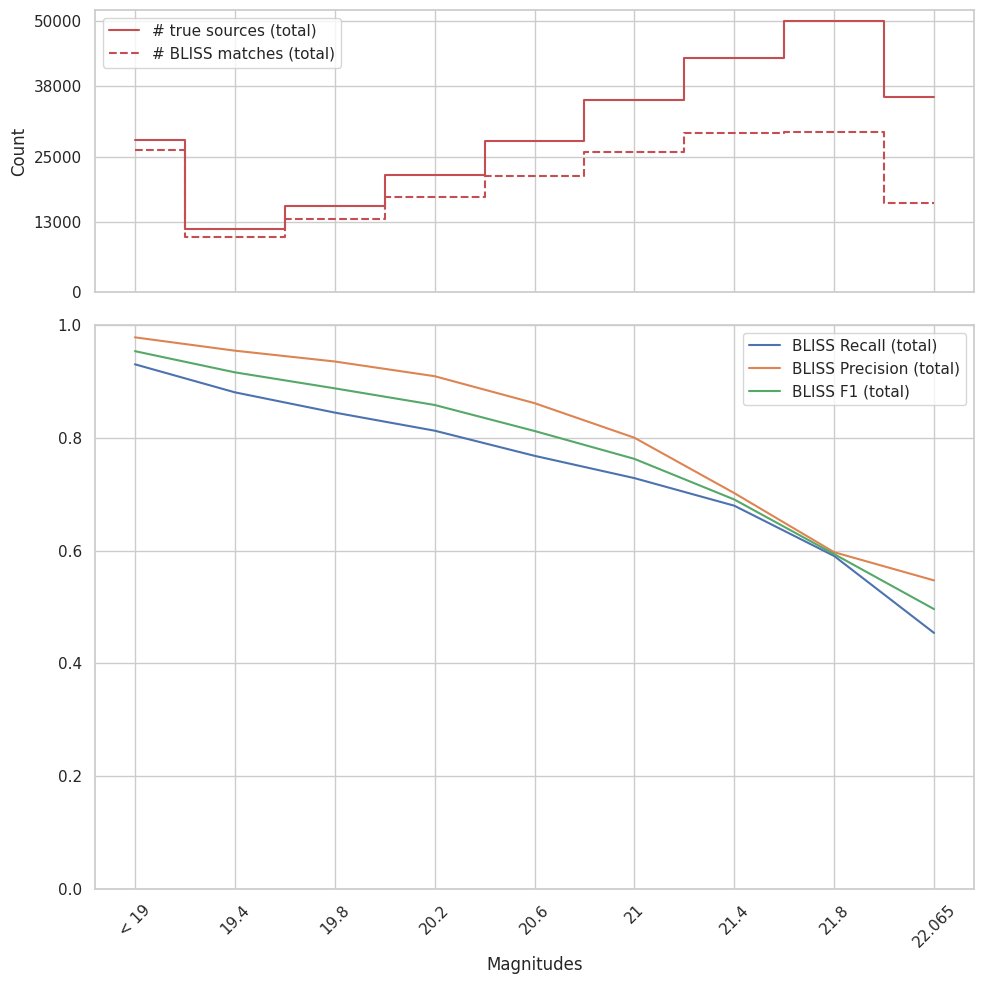

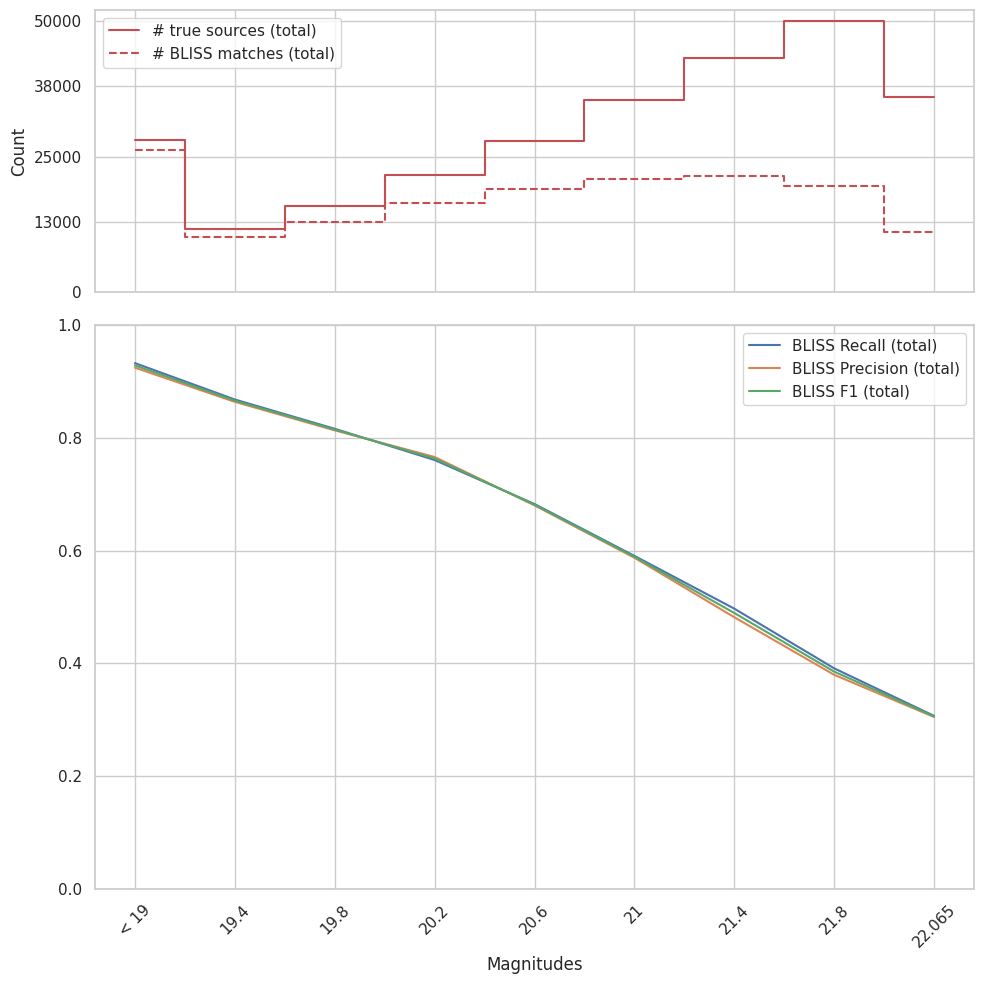

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric              ┃             DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              test/_loss               │           3.009976387023926           │
│        test/mode/detection_f1         │          0.7238695621490479           │
│     test/mode/detection_f1_bin_0      │          0.9536557197570801           │
│     test/mode/detection_f1_bin_1      │          0.9161348938941956           │
│     test/mode/detection_f1_bin_2      │          0.8877562880516052           │
│     test/mode/detection_f1_bin_3      │          0.8582914471626282           │
│     test/mode/detection_f1_bin_4      │          0.8121532797813416           │
│     test/mode/detection_f1_bin_5      │          0.7627093195915222           │
│     test/mode/detection_f1_bin_6      │           0.690685510635376           │
│     test/mode/detection_f1_bin_7      │          0.5938416719436646           │
│     test/mode/detection_f1_bin_8      │          0.49635738134384155          │
│     test/mode/detection_precision     │          0.7451754808425903           │
│  test/mode/detection_precision_bin_0  │           0.978142499923706           │
│  test/mode/detection_precision_bin_1  │          0.9545408487319946           │
│  test/mode/detection_precision_bin_2  │          0.9353461265563965           │
│  test/mode/detection_precision_bin_3  │          0.9092907309532166           │
│  test/mode/detection_precision_bin_4  │          0.8615028858184814           │
│  test/mode/detection_precision_bin_5  │          0.8001896142959595           │
│  test/mode/detection_precision_bin_6  │           0.702039897441864           │
│  test/mode/detection_precision_bin_7  │          0.5972086787223816           │
│  test/mode/detection_precision_bin_8  │          0.5472481846809387           │
│      test/mode/detection_recall       │          0.7037481665611267           │
│   test/mode/detection_recall_bin_0    │          0.9303649067878723           │
│   test/mode/detection_recall_bin_1    │          0.8806999325752258           │
│   test/mode/detection_recall_bin_2    │           0.844774603843689           │
│   test/mode/detection_recall_bin_3    │          0.8127090334892273           │
│   test/mode/detection_recall_bin_4    │          0.7681512236595154           │
│   test/mode/detection_recall_bin_5    │          0.7285831570625305           │
│   test/mode/detection_recall_bin_6    │          0.6796925663948059           │
│   test/mode/detection_recall_bin_7    │          0.5905123353004456           │
│   test/mode/detection_recall_bin_8    │          0.45412638783454895          │
│       test/sample/detection_f1        │          0.5789767503738403           │
│    test/sample/detection_f1_bin_0     │          0.9284031391143799           │
│    test/sample/detection_f1_bin_1     │          0.8658798933029175           │
│    test/sample/detection_f1_bin_2     │           0.814687967300415           │
│    test/sample/detection_f1_bin_3     │          0.7633518576622009           │
│    test/sample/detection_f1_bin_4     │          0.6814748048782349           │
│    test/sample/detection_f1_bin_5     │          0.5891071557998657           │
│    test/sample/detection_f1_bin_6     │          0.4894932806491852           │
│    test/sample/detection_f1_bin_7     │           0.385524183511734           │
│    test/sample/detection_f1_bin_8     │          0.3061046302318573           │
│    test/sample/detection_precision    │          0.5732352137565613           │
│ test/sample/detection_precision_bin_0 │          0.9243782162666321           │
│ test/sample/detection_precision_bin_1 │          0.8638271689414978           │
│ test/sample/detection_precision_bin_2 │          0.8133188486099243           │
│ test/sample/detection_precision_bin_3 │          0.76603865623

[{'test/_loss': 3.009976387023926,
  'test/mode/detection_precision': 0.7451754808425903,
  'test/mode/detection_recall': 0.7037481665611267,
  'test/mode/detection_f1': 0.7238695621490479,
  'test/mode/detection_precision_bin_0': 0.978142499923706,
  'test/mode/detection_precision_bin_1': 0.9545408487319946,
  'test/mode/detection_precision_bin_2': 0.9353461265563965,
  'test/mode/detection_precision_bin_3': 0.9092907309532166,
  'test/mode/detection_precision_bin_4': 0.8615028858184814,
  'test/mode/detection_precision_bin_5': 0.8001896142959595,
  'test/mode/detection_precision_bin_6': 0.702039897441864,
  'test/mode/detection_precision_bin_7': 0.5972086787223816,
  'test/mode/detection_precision_bin_8': 0.5472481846809387,
  'test/mode/detection_recall_bin_0': 0.9303649067878723,
  'test/mode/detection_recall_bin_1': 0.8806999325752258,
  'test/mode/detection_recall_bin_2': 0.844774603843689,
  'test/mode/detection_recall_bin_3': 0.8127090334892273,
  'test/mode/detection_recall_bi

In [33]:
encoder.use_checkerboard = False
trainer.test(encoder, datamodule=dataset)

## Assess the model and BLISS fit visually

In [34]:

from hydra.utils import instantiate

dataset = instantiate(cfg.predict.dataset)
dataset.prepare_data()

In [35]:
obs_image = torch.from_numpy(dataset[0]["image"][2][6:-6, 6:-6])

In [36]:
simulator = instantiate(cfg.simulator)
truth_images, _, _, _ = simulator.image_decoder.render_images(true_tile_cat_all, [(2583, 2, 136)])
true_recon_all = truth_images[0][2] + dataset[0]["background"][2][6:-6, 6:-6]

In [37]:
bliss_tile_cat = bliss_cat.to_tile_catalog(2, 5)
bliss_images, _, _, _ = simulator.image_decoder.render_images(bliss_tile_cat, [(2583, 2, 136)])
bliss_recon = bliss_images[0, 2] + dataset[0]["background"][2][6:-6, 6:-6]

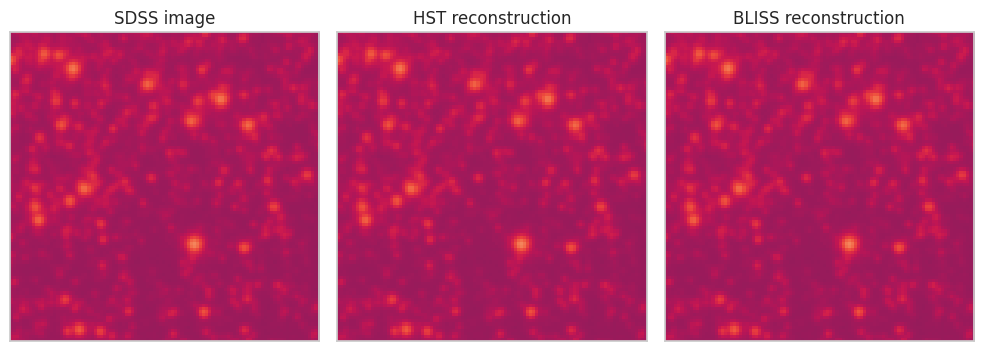

In [38]:
titles = ['SDSS image', 'HST reconstruction', 'BLISS reconstruction']

images = [obs_image, true_recon_all, bliss_recon]
images = [img.clip(max=obs_image.quantile(0.99)) for img in images]
images = [np.arcsinh((img - np.median(obs_image))) for img in images]

fig, axs = plt.subplots(1, 3, figsize=(10, 10))

vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)

for i, img in enumerate(images):
    ax = axs[i]
    ax.imshow(arcsinh_median, origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Flux Prior Elicitation

In [39]:
oob = (plocs_all[:, 1] > 210) & (plocs_all[:, 1] < 510)
oob &= (plocs_all[:, 0] > 530) & (plocs_all[:, 0] < 830)
oob &= ~in_bounds
oob.sum() # some of this region (about half) is outside of our HST cat coverage

tensor(31152)

In [40]:
hst_oob = hst_r_mag_all[oob]
hst_oob_nmgy = convert_mag_to_nmgy(hst_oob) * 1.15
hst_oob_mag = convert_nmgy_to_mag(hst_oob_nmgy)
training_data = hst_oob_nmgy[hst_oob_mag < 24]
training_data.shape[0], training_data.max().item()

(15752, 8037.071655549172)

In [41]:
from scipy.stats import truncpareto
alpha, trunc, loc, scale = truncpareto.fit(training_data)
alpha, trunc, loc, scale

(0.9859821185389767, 5685.588160703261, -1.162430157551662, 1.4137911256506595)

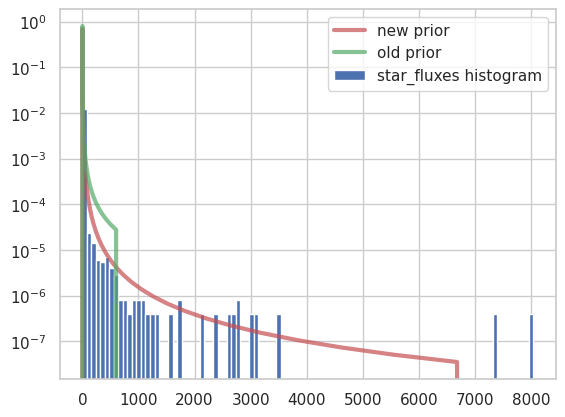

In [42]:
from scipy.stats import truncpareto

x = np.logspace(hst_oob_nmgy.log10().min(), hst_oob_nmgy.log10().max(), num=100)

_ = plt.plot(x, truncpareto.pdf(x, alpha, trunc, loc, scale), 'r-', lw=3, alpha=0.7, label='new prior')
_ = plt.plot(x, truncpareto.pdf(x, 0.5, 1014, 0, 0.63), 'g-', lw=3, alpha=0.7, label='old prior')
_ = plt.hist(hst_oob_nmgy, log=True, bins=100, label='star_fluxes histogram', density=True)
plt.legend()

[]

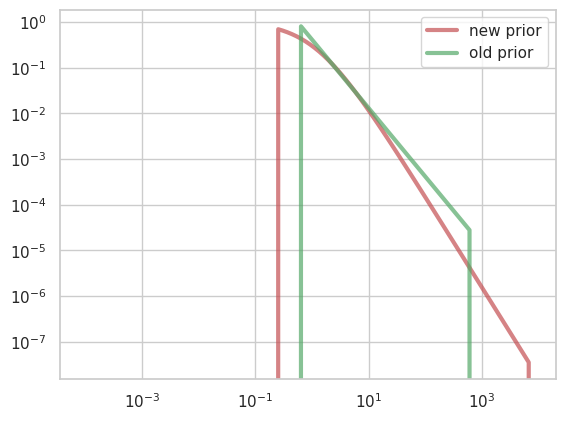

In [43]:
_ = plt.plot(x, truncpareto.pdf(x, alpha, trunc, loc, scale), 'r-', lw=3, alpha=0.7, label='new prior')
_ = plt.plot(x, truncpareto.pdf(x, 0.5, 1014, 0, 0.63), 'g-', lw=3, alpha=0.7, label='old prior')
plt.legend()
plt.loglog()

In [44]:
samples = truncpareto.rvs(alpha, trunc, loc, scale, size=1500)
sorted(samples, reverse=True)[:10]


[3406.524478182617,
 643.4777283292727,
 432.5994111719299,
 313.433535984035,
 305.15419927511596,
 295.0759158613764,
 294.0378029135814,
 289.23849541925136,
 247.55235693828894,
 240.10813970392837]

In [45]:
prior = instantiate(cfg.prior)
prior.sample().on_fluxes[0, :, :, :, 2].view(-1).topk(100)[0]

tensor([2914.1357, 1172.4301,  625.0680,  530.1812,  472.0424,  448.9833,
         383.0895,  338.0273,  317.8519,  316.9415,  300.5840,  225.1158,
         205.3708,  184.8215,  182.7741,  135.8285,  122.1196,  116.8877,
         115.1012,  112.3226,  105.8462,  102.4677,   97.3724,   95.4814,
          90.7175,   87.8431,   85.1315,   84.4001,   81.1745,   79.5453,
          78.8010,   75.7358,   75.3691,   71.2185,   67.0320,   64.4275,
          64.3424,   61.7118,   59.8125,   52.2378,   51.9916,   51.6892,
          49.8613,   48.7640,   46.0642,   45.2618,   44.5803,   44.4871,
          43.8039,   41.5779,   41.3977,   40.9463,   40.7341,   40.0772,
          39.0966,   38.7157,   38.3185,   37.5842,   37.3272,   36.8541,
          36.4868,   35.8971,   35.1713,   34.3662,   32.6937,   32.2456,
          31.7201,   31.5108,   29.9479,   29.7868,   29.5960,   28.9944,
          28.3868,   27.7347,   27.1881,   26.2961,   26.0707,   25.6766,
          25.5805,   25.3529,   25.283

In [46]:
# estimate rate with oob data
(hst_oob_mag < 24).sum() / (4 * 1e4)

tensor(0.3938)

# Assess the two-point correlation function

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

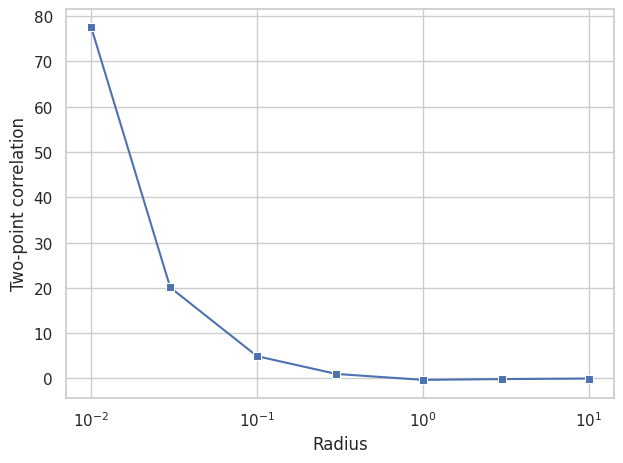

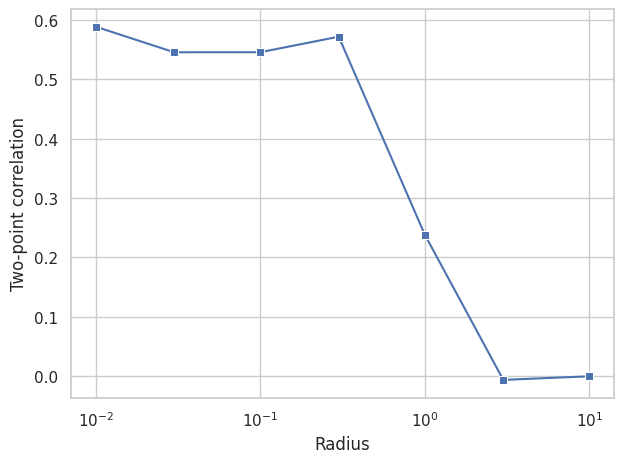

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric            ┃           DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            test/_loss            │        2.9420979022979736        │
│  test/mode/0.009999999776482582  │         77.6417236328125         │
│  test/mode/0.029999999329447746  │        20.085765838623047        │
│  test/mode/0.10000000149011612   │        4.919849395751953         │
│  test/mode/0.30000001192092896   │        1.0049967765808105        │
│          test/mode/1.0           │       -0.3113619089126587        │
│          test/mode/10.0          │      -0.010944187641143799       │
│          test/mode/3.0           │       -0.13510149717330933       │
│ test/sample/0.009999999776482582 │        0.5884984731674194        │
│ test/sample/0.029999999329447746 │        0.5453993082046509        │
│ test/sample/0.10000000149011612  │        0.5454620122909546        │
│ test/sample/0.30000001192092896  │        0.5715866088867188        │
│         test/sample/1.0          │       0.23843598365783691        │
│         test/sample/10.0         │      -9.21487808227539e-05       │
│         test/sample/3.0          │      -0.0061463117599487305      │
└──────────────────────────────────┴──────────────────────────────────┘

[{'test/_loss': 2.9420979022979736,
  'test/mode/0.009999999776482582': 77.6417236328125,
  'test/mode/0.029999999329447746': 20.085765838623047,
  'test/mode/0.10000000149011612': 4.919849395751953,
  'test/mode/0.30000001192092896': 1.0049967765808105,
  'test/mode/1.0': -0.3113619089126587,
  'test/mode/3.0': -0.13510149717330933,
  'test/mode/10.0': -0.010944187641143799,
  'test/sample/0.009999999776482582': 0.5884984731674194,
  'test/sample/0.029999999329447746': 0.5453993082046509,
  'test/sample/0.10000000149011612': 0.5454620122909546,
  'test/sample/0.30000001192092896': 0.5715866088867188,
  'test/sample/1.0': 0.23843598365783691,
  'test/sample/3.0': -0.0061463117599487305,
  'test/sample/10.0': -9.21487808227539e-05}]

In [47]:
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.main import train

with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg5 = compose("m2_config", {
        "train.trainer.logger=null",
        "train.trainer.max_epochs=0",
        "train.pretrained_weights=/home/regier/bliss/output/jun11_yaml_vd/version_0/checkpoints/best_encoder.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/regier/toy_m2",
        "+train.trainer.num_sanity_val_steps=0",
        "cached_simulator.splits=0:10/10:20/0:100",
#        "encoder.double_detect=false",
    })

# setup dataset, encoder, and trainer
cfg5.train.encoder.metrics.metrics = [{'_target_': 'case_studies.spatial_tiling.two_point_metric.TwoPointMetric'}]
train_cfg = cfg5.train

dataset = instantiate(train_cfg.data_source)
encoder = instantiate(train_cfg.encoder)
trainer = instantiate(train_cfg.trainer)

# load pretrained weights
enc_state_dict = torch.load(train_cfg.pretrained_weights)
if train_cfg.pretrained_weights.endswith(".ckpt"):
    enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)

# test
trainer.test(encoder, datamodule=dataset)

In [48]:
m = encoder.sample_metrics["TwoPointMetric"]
two_pt_checkerboard = m.compute().values()
m.reset()
two_pt_checkerboard

/home/regier/bliss/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric TwoPointMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


dict_values([tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)])

Findings from spotchecking sources of nonzero two-point correlation above:
* two pairs of sources with modes within 1e-4: catty corner, need 4 color checkerboard
* one pair of sources with modes within 1e-2: consecutive columns in a row, near a corner; one source a second detect; need conditioning info to second detect
* one pair of sources with sampled modes within 0.1: a double detect solidly within a tile; high uncertainty about whether second exists (it doesn't); first correctly identified; second detected source hovers around the pixel (of 4) containing the source; need conditioning info for the second detect

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

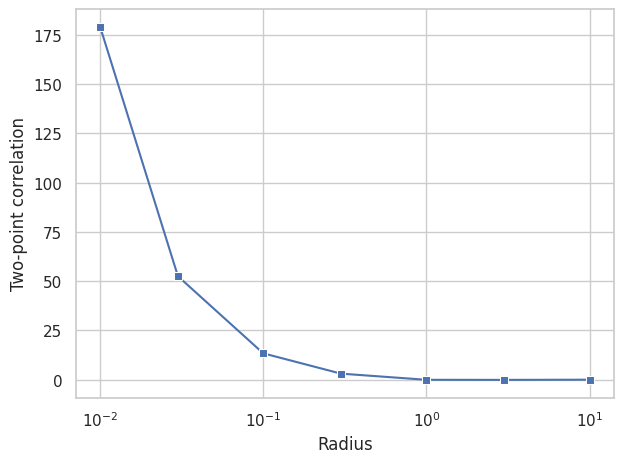

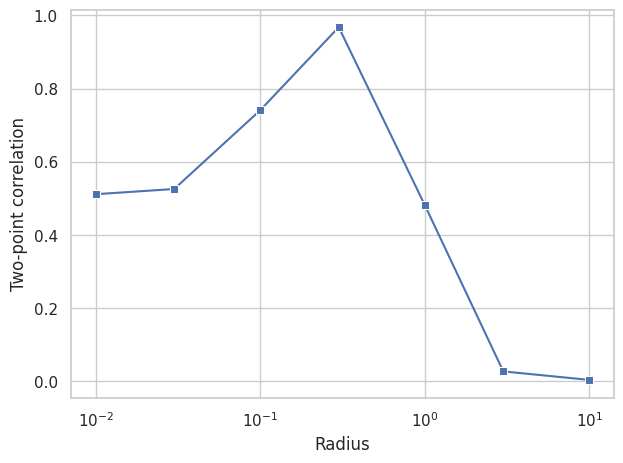

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Test metric            ┃           DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            test/_loss            │        3.013946771621704         │
│  test/mode/0.009999999776482582  │        179.22015380859375        │
│  test/mode/0.029999999329447746  │        52.51699447631836         │
│  test/mode/0.10000000149011612   │        13.376335144042969        │
│  test/mode/0.30000001192092896   │        3.061882495880127         │
│          test/mode/1.0           │       -0.05880939960479736       │
│          test/mode/10.0          │      -0.006470739841461182       │
│          test/mode/3.0           │       -0.10622668266296387       │
│ test/sample/0.009999999776482582 │        0.5113447904586792        │
│ test/sample/0.029999999329447746 │        0.5255069732666016        │
│ test/sample/0.10000000149011612  │        0.7405925989151001        │
│ test/sample/0.30000001192092896  │        0.9674584865570068        │
│         test/sample/1.0          │       0.48170948028564453        │
│         test/sample/10.0         │       0.004135847091674805       │
│         test/sample/3.0          │       0.027384281158447266       │
└──────────────────────────────────┴──────────────────────────────────┘

[{'test/_loss': 3.013946771621704,
  'test/mode/0.009999999776482582': 179.22015380859375,
  'test/mode/0.029999999329447746': 52.51699447631836,
  'test/mode/0.10000000149011612': 13.376335144042969,
  'test/mode/0.30000001192092896': 3.061882495880127,
  'test/mode/1.0': -0.05880939960479736,
  'test/mode/3.0': -0.10622668266296387,
  'test/mode/10.0': -0.006470739841461182,
  'test/sample/0.009999999776482582': 0.5113447904586792,
  'test/sample/0.029999999329447746': 0.5255069732666016,
  'test/sample/0.10000000149011612': 0.7405925989151001,
  'test/sample/0.30000001192092896': 0.9674584865570068,
  'test/sample/1.0': 0.48170948028564453,
  'test/sample/3.0': 0.027384281158447266,
  'test/sample/10.0': 0.004135847091674805}]

In [49]:
encoder.use_checkerboard = False
trainer.test(encoder, datamodule=dataset)

In [50]:
m = encoder.sample_metrics["TwoPointMetric"]
two_pt_ind = m.compute().values()
two_pt_ind

/home/regier/bliss/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric TwoPointMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


dict_values([tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)])

dict_values([tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan)])

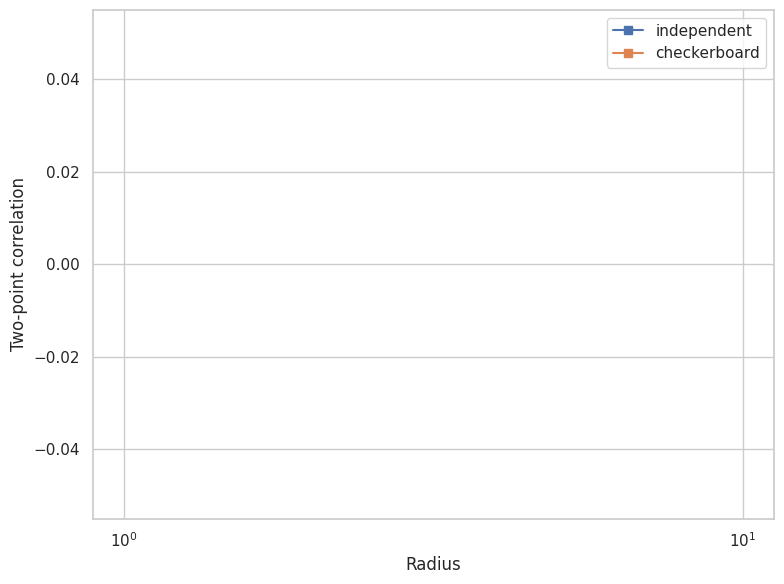

In [51]:
radius = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]

plt.figure(figsize=(8, 6))  # Create a new figure with a specific size
plt.plot(radius, two_pt_ind, marker="s", label="independent")
plt.plot(radius, two_pt_checkerboard, label="checkerboard", marker="s")
plt.legend()
plt.xscale("log")  # Set the x-axis scale to logarithmic
plt.xlabel("Radius")
plt.ylabel("Two-point correlation")

plt.tight_layout()
two_pt_ind

# Semi-synthetic M2 inference

In [52]:
with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg = compose("m2_config", {
        "encoder.tiles_to_crop=3",
        "predict.weight_save_path=/home/regier/bliss/output/jun11_yaml_vd/version_0/checkpoints/best_encoder.ckpt",
 #       "encoder.double_detect=false"
        })

d2 = deepcopy(true_cat_all)
d2["plocs"] += 6
true_cat_pad = FullCatalog(112, 112, d2)

truth_images, _, _, _ = simulator.image_decoder.render_images(
    true_cat_pad.to_tile_catalog(2, 11), [(2583, 2, 136)]
)

In [53]:
from torch.distributions import Normal

true_recon_all = truth_images[0] + dataset[0]["background"]
true_recon_all = Normal(true_recon_all, true_recon_all.sqrt()).sample()

In [59]:
encoder = instantiate(cfg.encoder)
enc_state_dict = torch.load("/home/regier/bliss/output/jun11_yaml_vd/version_0/checkpoints/best_encoder.ckpt")
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
encoder.eval()

batch = {
    "images": true_recon_all.unsqueeze(0),
    "background": dataset[0]["background"].unsqueeze(0),
}

In [60]:
encoder.use_checkerboard = False

with torch.no_grad():
    mode_cat, sample_cat = encoder.predict_step(batch, 0).values()

mode_cat = mode_cat.to_full_catalog()
matching = matcher.match_catalogs(true_cat_all, mode_cat)
metric = metrics(true_cat_all, mode_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

(tensor(0.5818), tensor(0.6043), tensor(0.5928))

In [61]:
encoder.use_checkerboard = True

with torch.no_grad():
    mode_cat, sample_cat = encoder.predict_step(batch, 0).values()

mode_cat = mode_cat.to_full_catalog()
matching = matcher.match_catalogs(true_cat_all, mode_cat)
metric = metrics(true_cat_all, mode_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

(tensor(0.5781), tensor(0.6185), tensor(0.5976))

In [62]:
m = metrics["detection_performance"]
recall = (m.n_true_matches / m.n_true_sources)[:-1]
precision = (m.n_est_matches / m.n_est_sources)[:-1]
semisynthetic = {"recall": recall, "precision": precision}
semisynthetic

{'recall': tensor([0.9423, 0.7989, 0.8505, 0.6868, 0.6439, 0.6058, 0.5227, 0.3429, 0.2778]),
 'precision': tensor([0.9655, 0.9392, 0.9091, 0.8735, 0.7548, 0.6680, 0.5205, 0.3532, 0.3089])}

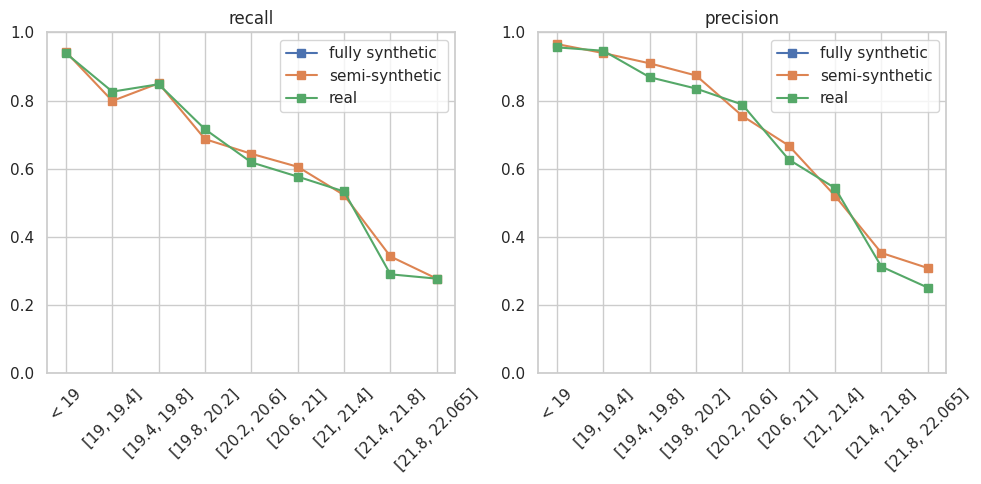

In [63]:
titles = ["fully synthetic", "semi-synthetic", "real"]
scores = [fully_synthetic, semisynthetic, real]

mbc = m.mag_bin_cutoffs
xlabels = [f"[{mbc[i]}, {mbc[i+1]}]" for i in range(len(mbc) - 1)]
xlabels = ["< " + str(mbc[0])] + xlabels + ["> " + str(mbc[-1])]
xlabels = xlabels[:-1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, score in enumerate(scores):
    axs[0].plot(score["recall"], marker="s", label=titles[i])
    axs[1].plot(score["precision"], marker="s", label=titles[i])

axs[0].set_title("recall")
axs[1].set_title("precision")

for ax in axs:
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_ylim([0, 1])
    ax.legend()

plt.tight_layout()